# Linear Rgression Using Neural Networks

In [321]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [322]:
from sklearn import datasets, model_selection
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [323]:
X,y = datasets.make_regression(n_samples=100000, n_features=50,
                                       n_informative=40, n_targets=1,
                                       random_state=313)


In [324]:
X.shape, y.shape

((100000, 50), (100000,))

In [325]:
batch_size = 32
epochs = 2

In [326]:
class CustomDataset(Dataset):
  def __init__(self, X, y, scale=True):
    if not torch.is_tensor(X):
      if scale:
        self.X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.X = self.X.to(torch.float32)

    if not torch.is_tensor(y):
      self.y = torch.from_numpy(y)
      self.y = self.y.to(torch.float32)

  def __len__(self):
        return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [327]:
dataset = CustomDataset(X,y)

In [328]:
train_dataset, test_dataset = random_split(dataset, (0.8, 0.2))

In [329]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [330]:
print(f'There are {len(train_dataset)} items in the training set')
print(f'There are {len(test_dataset)} items in the test set')
print(f'There are {len(train_loader)} batches in the train loader')
print(f'There are {len(test_loader)} batches in the testloader')

There are 80000 items in the training set
There are 20000 items in the test set
There are 2500 batches in the train loader
There are 625 batches in the testloader


In [331]:
# verify
32*2500, 32*625

(80000, 20000)

In [332]:
class LinearRegression(nn.Module):
  def __init__(self):
      super(LinearRegression, self).__init__()

      self.hidden1 = nn.Linear(50,16,True)
      self.relu = nn.ReLU()
      self.dropout1 = nn.Dropout(p=0.1)
      self.hidden2 = nn.Linear(16,8,True)
      self.dropout2 = nn.Dropout(p=0.05)
      self.out = nn.Linear(8,1,True)

  def forward(self,x):
    out = self.hidden1(x)
    out = self.relu(out)
    out = self.dropout1(out)
    out = self.hidden2(out)
    out = self.relu(out)
    out = self.dropout2(out)
    out = self.out(out)
    return out

In [333]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

In [334]:
device

device(type='cuda')

In [335]:
model = LinearRegression()

if device == torch.device("cuda"):
  model = model.to(device)

In [336]:
model

LinearRegression(
  (hidden1): Linear(in_features=50, out_features=16, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (dropout2): Dropout(p=0.05, inplace=False)
  (out): Linear(in_features=8, out_features=1, bias=True)
)

In [337]:
# define loss and optimizer

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [338]:
# understand what's happening
itr = 0

for i,(input,y) in enumerate(train_loader):

      if itr == 1:
        break

      if device == torch.device("cuda"):
          input = input.to(device)
          y = y.to(device)


      print(f'Input Shape: {input.shape}')
      print(f'Output Shape: {y.shape}')

      yhat = model(input)

      print(f'Prediction Shape: {yhat.shape}')
      print(f'Prediction: {yhat}')

      loss = loss_fn(yhat, y)
      print(f'Loss: {loss.item()}')

      itr += 1

Input Shape: torch.Size([32, 50])
Output Shape: torch.Size([32])
Prediction Shape: torch.Size([32, 1])
Prediction: tensor([[-0.1209],
        [-0.0524],
        [-0.0288],
        [-0.0003],
        [ 0.0905],
        [-0.0302],
        [-0.2005],
        [ 0.0233],
        [-0.0492],
        [-0.0561],
        [-0.1018],
        [-0.0593],
        [-0.0028],
        [-0.0042],
        [-0.1041],
        [-0.0591],
        [-0.0852],
        [-0.1262],
        [-0.0409],
        [-0.0167],
        [-0.0039],
        [ 0.0115],
        [ 0.1126],
        [-0.0678],
        [-0.0154],
        [-0.0005],
        [-0.0445],
        [ 0.0210],
        [-0.0183],
        [-0.1466],
        [-0.1178],
        [-0.0439]], device='cuda:0', grad_fn=<AddmmBackward0>)
Loss: 109498.046875


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [339]:
epochs = 5

train_loss, test_loss = list(), list()
best_mse, best_weights = None, None

for epoch in tqdm(range(epochs)):
  correct = 0
  itrs = 0
  itr_loss = 0.0

  model.train()

  for i,(input,y) in enumerate(train_loader):

      if device == torch.device("cuda"):
          input = input.to(device)
          y = y.to(device)

      optimizer.zero_grad() # clear the accumulated gradients

      output = model(input) # perform forward propogation

      loss = loss_fn(output, y) # compute loss
      itr_loss += loss.item()
      loss.backward() # perform backpropogation

      optimizer.step() # update weights (kernel elements in CNN)

      itrs+=1

  train_loss.append(itr_loss/itrs)


  # test the model
  model.eval()

  correct = 0
  itrs = 0
  itr_loss = 0.0

  for i,(input,y) in enumerate(test_loader):

      if device == torch.device("cuda"):
          input = input.to(device)
          y = y.to(device)

      output = model(input)

      loss = loss_fn(output, y)
      itr_loss += loss.item()

      itrs += 1

  test_loss.append(itr_loss/itrs)

  if len(test_loss) == 1 or test_loss and itr_loss / itrs < test_loss[-1]:
    best_mse = itr_loss / itrs
    best_weights = model.state_dict()

  print(f'\nEpoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]:.3f}, Testing Loss: {test_loss[-1]:.3f}')

 20%|██        | 1/5 [00:04<00:18,  4.65s/it]


Epoch 1/5, Training Loss: 114608.438, Testing Loss: 113042.781


 40%|████      | 2/5 [00:08<00:12,  4.30s/it]


Epoch 2/5, Training Loss: 114585.889, Testing Loss: 113032.453


 60%|██████    | 3/5 [00:12<00:08,  4.19s/it]


Epoch 3/5, Training Loss: 114587.630, Testing Loss: 113064.818


 80%|████████  | 4/5 [00:17<00:04,  4.35s/it]


Epoch 4/5, Training Loss: 114586.761, Testing Loss: 113025.977


100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


Epoch 5/5, Training Loss: 114584.512, Testing Loss: 113010.155


In [340]:
print(f'MSE Loss: {best_mse}')
print(f'RMSE Loss: {np.sqrt(best_mse)}')

MSE Loss: 113042.7807875
RMSE Loss: 336.2183528415723


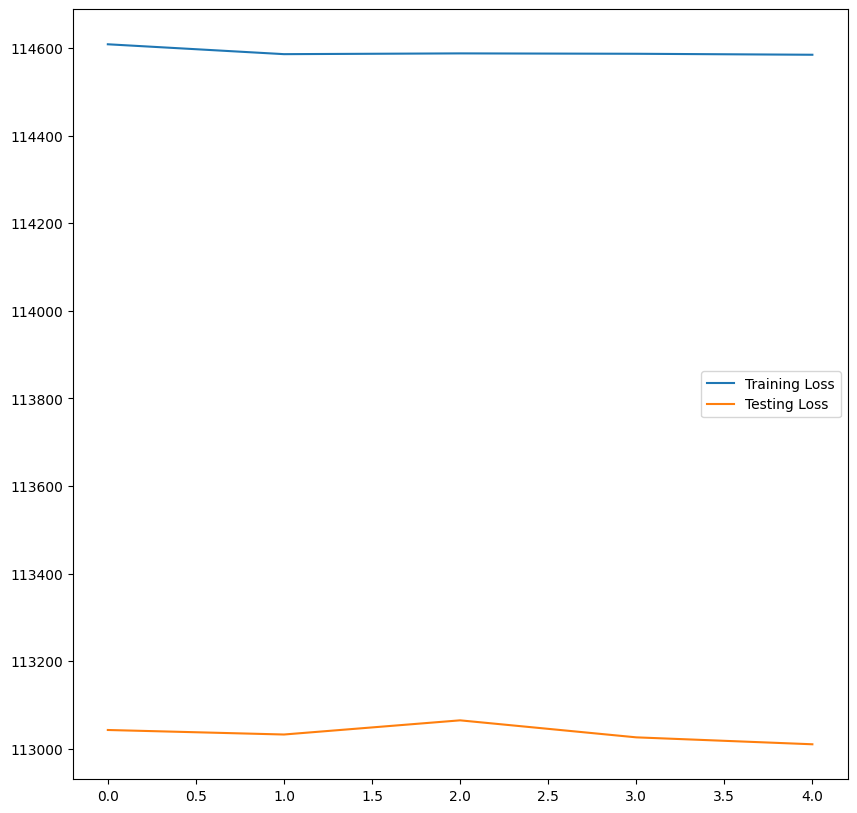

In [341]:
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

In [342]:
torch.save(best_weights,'LinearRegression.pt')

## Miscellaneous Playground

In [343]:
layer = nn.Linear(3,1)

In [344]:
layer.weight, layer.bias

(Parameter containing:
 tensor([[ 0.5594, -0.3257,  0.2205]], requires_grad=True),
 Parameter containing:
 tensor([-0.1391], requires_grad=True))

In [345]:
layer.weight.dtype, layer.bias.dtype

(torch.float32, torch.float32)

In [346]:
x = torch.tensor([1,2,3],dtype=torch.float32, requires_grad=False)

In [347]:
x.shape

torch.Size([3])

In [348]:
layer(x)

tensor([0.4304], grad_fn=<AddBackward0>)

In [349]:
print(layer.weight.detach().numpy()*x.numpy())

[[ 0.5594247  -0.65142167  0.66147137]]


In [350]:
print((layer.weight.detach().numpy()*x.numpy()).sum())

0.5694744
